In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.patches import Rectangle
from IPython.display import display
import stumpy
import os
import zipfile
from tqdm.notebook import tqdm_notebook
from datetime import datetime

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/'
overall_filename = 'february_data.csv'

In [6]:
# # Unzip files with data

# with zipfile.ZipFile("february_data.zip", 'r') as zip_ref:
#     zip_ref.extractall()

# with zipfile.ZipFile("february_data_by_second.zip", 'r') as zip_ref:
#     zip_ref.extractall()

In [7]:
# Helper functions. They do what the function name suggests

def read_in_file(filename, keep_columns=None, drop_columns=None, time_format='%Y-%m-%dT%H:%M:%S.%f'):
    df = pd.read_csv(filename)

    if 'time' in df.columns.tolist():
        df.time = pd.to_datetime(df.time, format=time_format)

    df = df.set_index('time')

    if keep_columns is not None:
        df = df[keep_columns]

    if drop_columns is not None:
        df = df.drop(columns=drop_columns)

    return df

def groupby_second(df, agg='mean'):
    '''@param df: pandas DataFrame with index as a DateTimeIndex'''
    df = df.groupby(by=[df.index.year, df.index.month, df.index.day, df.index.hour, df.index.minute, df.index.second]).agg(agg)
    df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
                df.index.get_level_values(1).astype(str) + '-' +
                df.index.get_level_values(2).astype(str) + 'T' +
                df.index.get_level_values(3).astype(str) + ':' +
                df.index.get_level_values(4).astype(str) + ':' +
                df.index.get_level_values(5).astype(str),
                format='%Y-%m-%dT%H:%M:%S')
    return df

def do_matrix_profile_nd(df, m):
    mps, indices = stumpy.mstump(df, m)
    motifs_idx = np.argsort(mps, axis=1)[:, 0]
    nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(18,5*df.shape[1]))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='8')
        axs[k].plot(np.arange(df.shape[0]), df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='8')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='8')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='8')

        # axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        # if dim_name != 'T3':
        #     axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        #     axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
        # else:
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

    plt.show()

def do_matrix_profile_1d(df, m):
    mp = stumpy.stump(df.iloc[:, 0], m)
    discord_idx = np.argsort(mp[:, 0])[-1]
    nearest_neighbor_distance = mp[discord_idx, 0]

    fig, axs = plt.subplots(2, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(18,8))
    plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='12')

    axs[0].plot(df.iloc[:, 0].values)
    axs[0].set_ylabel(list(df.columns)[0], fontsize='12')
    rect = Rectangle((discord_idx, 0), m, max(df.iloc[:, 0]), facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='12')
    axs[1].set_ylabel('Matrix Profile', fontsize='12')
    axs[1].axvline(x=discord_idx, linestyle="dashed")
    axs[1].plot(mp[:, 0])
    plt.show()

def do_matrix_profile(df, m, t1=None, t2=None):
    '''@param m: the window or kernel size for the matrix profile'''

    if t1 is not None \
        and t2 is not None \
        and t1 < t2:
        df = df[(df.index >= t1) & (df.index < t2)]

    if len(df.columns) > 1: # If you have more than one dimension
        do_matrix_profile_nd(df, m)
    else:
        do_matrix_profile_1d(df, m)


def plot_time_window(df, t1, t2, col):
    df = df[(df.index >= t1) & (df.index < t2)]
    sns.lineplot(x=df.index, y=df[col])
    plt.show()

In [3]:
# Unzip all the contents of the data folder

# for file in os.listdir(data_directory):

#     if "zip" not in file:
#         continue
    
#     with zipfile.ZipFile(data_directory + file, 'r') as zip_ref:
#         zip_ref.extractall(data_directory)
#     os.remove(data_directory + file)

In [4]:
overall_filename = 'february_data.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files
    
    df = read_in_file(data_directory + file)
    # df = groupby_second(df)
    # df.dropna(inplace=True)

    if len(df) > 0:
        if i == 0:
            df.to_csv(overall_filename)
        else:
            df.to_csv(overall_filename, mode='a', header=False)

In [ ]:
overall_filename = 'february_data_by_second.csv'
indx_files = list(enumerate(os.listdir(data_directory)))
for i, file in tqdm_notebook( indx_files ): # For each of our february files
    
    df = read_in_file(data_directory + file)
    df = groupby_second(df)
    df.dropna(inplace=True)

    if len(df) > 0:
        if i == 0:
            df.to_csv(overall_filename)
        else:
            df.to_csv(overall_filename, mode='a', header=False)

In [8]:
df_overall = pd.read_csv('february_data_by_second.csv')
df_overall.time = df_overall.time.astype(str)
df_overall.set_index(pd.to_datetime(df_overall.time, errors='coerce'), drop=True, inplace=True)
df_overall.drop(columns=['time'], inplace=True)

In [9]:
df_overall = df_overall.dropna()

In [44]:
# t1 = datetime(year=2022, 
#               month=2, 
#               day=18, 
#               hour=4, 
#               minute=25, 
#               second=0)
# t2 = datetime(year=2022,
#               month=2, 
#               day=18, 
#               hour=10, 
#               minute=7, 
#               second=0)

t1 = datetime(year=2022, 
              month=2, 
              day=20, 
              hour=14, 
              minute=16, 
              second=0)
t2 = datetime(year=2022,
              month=2, 
              day=20, 
              hour=17, 
              minute=10, 
              second=0)

# t1 = datetime(year=2022, 
#               month=2, 
#               day=21, 
#               hour=21, 
#               minute=18, 
#               second=20)
# t2 = datetime(year=2022,
#               month=2, 
#               day=21, 
#               hour=23, 
#               minute=24, 
#               second=40)

cols = ['Continuous Bond Vibration']
window_sizes = range(60, 600, 60)

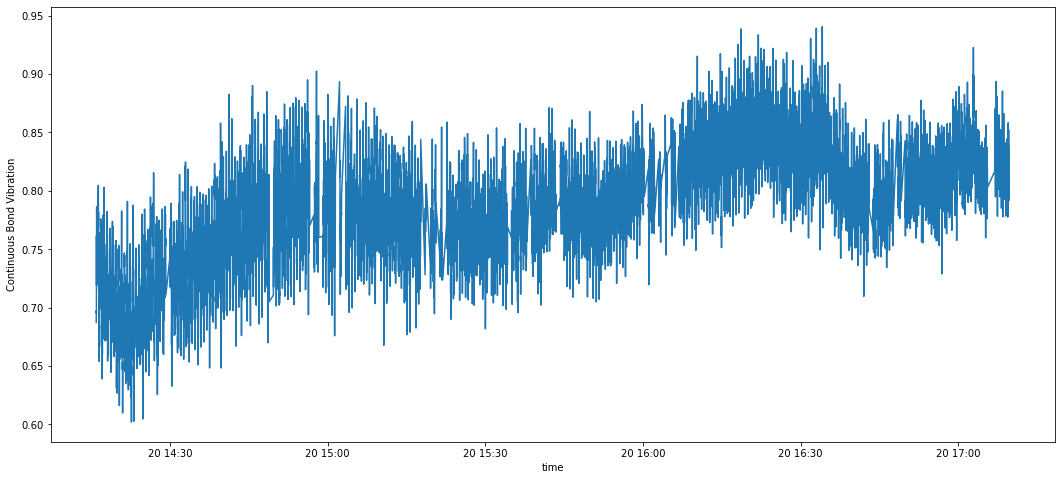

In [45]:
figure(figsize=(18,8))
plot_time_window(df_overall, t1, t2, cols[0])

In [48]:
for m in window_sizes:
    print("Window size (m): {}".format(m/60))
    do_matrix_profile(df_overall[cols], m, t1, t2)